![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Explainability for Random Forest Models

In this Notebook we will show you different methods that can be used for interpreting Random Forest models. We will demonstrate you how to compare those methods and choose the appropriate one.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button. This will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/2025-HIDA-Spring/xai-for-random-forest/Gen-5-Tutorial_XAI_for_RandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
from google.colab import drive
drive.mount('/content/drive')

# Switch to correct folder'
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
# Don't run this cell if you already cloned the repo
%rm -r XAI-Tutorials
!git clone --branch 2025-HIDA-Spring https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

Cloning into 'XAI-Tutorials'...
remote: Enumerating objects: 3990, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 3990 (delta 231), reused 145 (delta 144), pack-reused 3717 (from 2)
Receiving objects: 100% (3990/3990), 388.08 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (2491/2491), done.
Updating files: 100% (39/39), done.


In [3]:
# Install al required dependencies and package versions
%cd XAI-Tutorials
!pip install -r requirements_xai-for-random-forest.txt
%cd xai-for-random-forest

/content/drive/MyDrive/XAI-Tutorials
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.2/528.2 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=34925c73e9867f4500e2f2124db751f1f7238fe6d39cc1f1

### Imports

Let's start with importing all required Python packages.

In [4]:
# Load the required packages

import sys
import pickle
import numpy as np
import pandas as pd


import shap
from fgclustering import FgClustering
from sklearn.metrics import get_scorer
from sklearn.inspection import permutation_importance

sys.path.append('./')
import utils

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [5]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The Palmer Pinguins Dataset

In this notebook, we will work with the **Palmer penguins dataset**, containing the information on 3 different species of penguins - Adelie, Chinstrap, and Gentoo - which were observed in the Palmer Archipelago near Palmer Station, Antarctica. The datasets consist of a total of 344 penguins, together with their size measurements, clutch observations, and blood isotope ratios. Our goal is to **predict the species** of Palmer penguins and find out the major differences among them.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_penguins.png?raw=true" width="500" /></center>

<font size=1> Source: [Link](https://allisonhorst.github.io/palmerpenguins/)

In the notebook [*Gen-0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb*](./Gen-0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook is the interpretation of the previously trained model.

In [6]:
# Load and unpack the data
with open('../models/model_rf_penguins.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_penguins = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(model_penguins.score(X_train, y_train)*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(model_penguins.score(X_test, y_test)*100,2)} % accuracy.')

Model Performance on training data: 99.62 % accuracy.
Model Performance on test data: 95.52 % accuracy.


The generalization of our model is very good with 95% test accuracy. However, you should keep in mind that interpreting a low performing model can lead to wrong conclusions.

Below, we plot the correlation between the model features that we should be aware of when using some of the XAI methods.

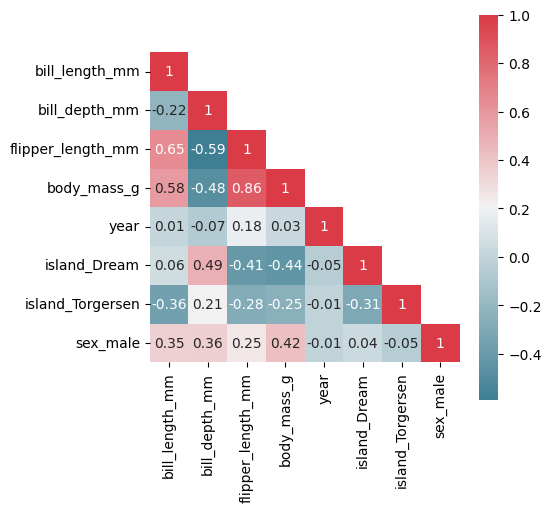

In [7]:
utils.plot_correlation_matrix(X_train)

--------

## Now, what are our possibilities to interpret a Random Forest model?

### Interpretation with Feature Importance Measures

#### Permutation Feature Importance

In the [Gen-1-Tutorial_PermutationFeatureImportance.ipynb](./Gen-1-Tutorial_PermutationFeatureImportance.ipynb) notebook you were introduced to the model-agnostic Permutation Feature Importance. Recall, the Permutation Feature Importance is defined to be the decrease in a model score when a single feature value is randomly permuted. This procedure breaks the relationship between the feature and the target. Thus the drop in the model score is indicative of how much the model depends on the feature. Lets now apply it to our penguins dataset:

<font color='green'>

#### Task 1: Calculate permutation feature importance for the trained Random Forest model. Therefore, define the appropriate scorer and compute the permutation feature importance scores by filling in the two lines below.


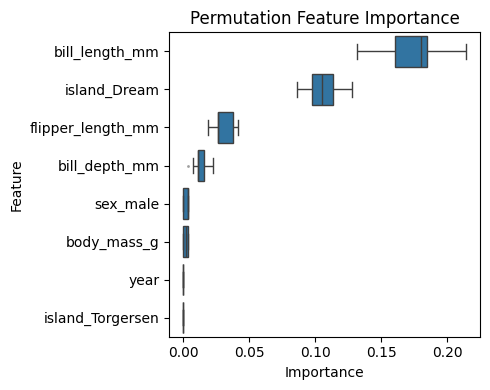

In [8]:
scorer = get_scorer("accuracy")
result = permutation_importance(model_penguins, X_train, y_train, n_repeats=20, random_state=seed)
utils.plot_permutation_feature_importance(result=result, data=X_train, title="Permutation Feature Importance", figsize=(5,4))

<font color='green'>

#### Question 1: How big is the influence of the most important feature on the model performance and what does it tell us?

<font color='grey'>

#### Your Answer:
The most important feature is 'bill_length_mm' with an importance score around 0.38. This means that if we randomly shuffle the values of 'bill_length_mm', the model's accuracy decreases by approximately 38%. This highlights that bill length is a crucial feature for the model to distinguish between penguin species.

#### Random Forest Feature Importance

An alternative to Permutation Feature Importance is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute `feature_importances_` .

Lets plot the feature importance based on mean decrease in impurity:

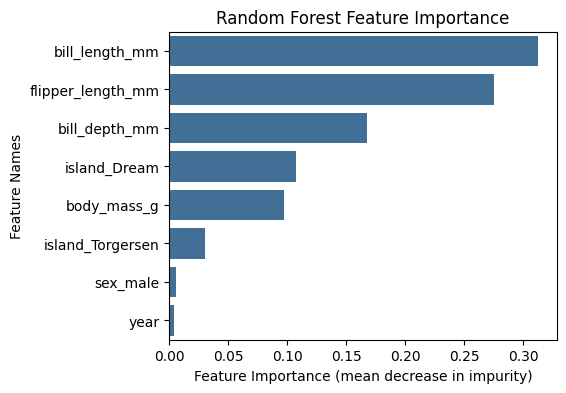

In [10]:
utils.plot_impurity_feature_importance(model_penguins.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance")

<font color='green'>

#### Question 2: Inspect the differences between the results of the two feature importance plots. What do you notice?
_Hint:_ Take a look at the correlation plot above!

<font color='grey'>

#### Your Answer:
The Permutation Feature Importance highlights 'bill_length_mm' as the most important feature, followed by 'flipper_length_mm'. The Random Forest Feature Importance, however, shows 'flipper_length_mm' as the most important, followed by 'bill_length_mm' and 'bill_depth_mm'.

This discrepancy can be attributed to the correlation between 'bill_length_mm' and 'bill_depth_mm'. Since these features are correlated, the Random Forest Feature Importance might over-emphasize their individual contributions. Permutation Feature Importance, being model-agnostic, is less sensitive to this issue and provides a more accurate view of feature importance.

### Interpretation with SHAP

In the [Gen-3-Tutorial_SHAP.ipynb](./Gen-3-Tutorial_SHAP.ipynb) notebook you, were introduced to the model-agnostic SHAP method. Recall, with SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

<font color='green'>

#### Task 2: Run SHAP on the trained Random Forest model. Therefore, define the appropriate explainer and calculate the SHAP values by filling in the lines below.

In [ ]:
# run SHAP
explainer = ...
shap_values = explainer(X_train)

# get original unscaled feature values
scaler = data_and_model[5]
shap_values.data = pd.DataFrame(scaler.inverse_transform(X_train), columns = X_train.columns).round(4)

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

Remember that the SHAP values explain why a prediction for a single observation is different from the average prediction for all the observations in the data set. For our penguins classifier, the shap explainer produces three expected values, corresponding to the average predicted probability for each class, which is essentially the predicted class frequency in the dataset.

In [ ]:
# average prediction for the dataset
ev = explainer.expected_value
pm = np.mean(model_penguins.predict_proba(X_train), axis=0)

print(f'Models average prediction for our data set is for class 0: {round(pm[0],3)}, for class 1: {round(pm[1],3)}, for class 2: {round(pm[2],3)}')
print(f'Expected value for our data set is for class 0: {round(ev[0],3)}, for class 1: {round(ev[1],3)}, for class 2: {round(ev[2],3)}')

Models average prediction for our data set is for class 0: 0.446, for class 1: 0.204, for class 2: 0.35
Expected value for our data set is for class 0: 0.446, for class 1: 0.204, for class 2: 0.35


To get a general overview on the features with the highest contributions, we can plot the average absolute SHAP values for each penguin species.

<font color='green'>

#### Task 3: Plot the summary plot as barplot for the absolute SHAP values by filling in the line below.
_Hint:_ check out the SHAP Tutorial's extra material for multi-class SHAP analysis!

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_10743/3206266506.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


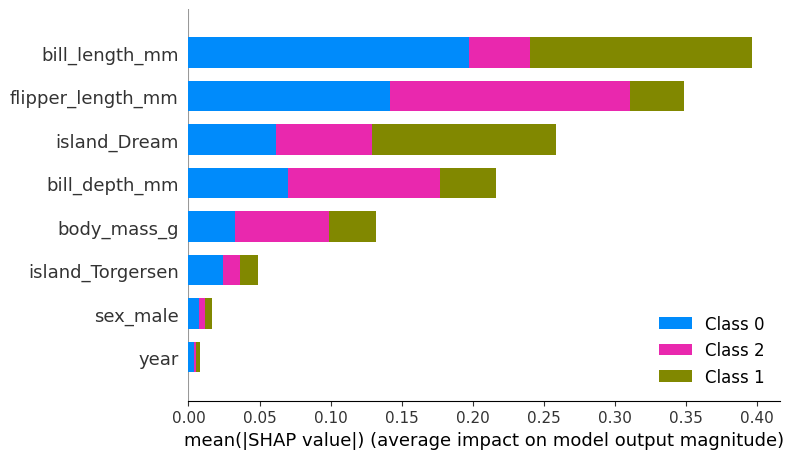

In [ ]:
...

For a more granular view we can use the beeswarm or violin plots. Remember, those have to be plotted class-wise.

<font color='green'>

#### Task 4: Plot the summary plot as a beeswarm plot for the SHAP values by filling in the line below. For multi-class calssification, it has to be plotted per class.
_Hint:_ check out the SHAP Tutorial's extra material for multi-class SHAP analysis!

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_10743/963270454.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


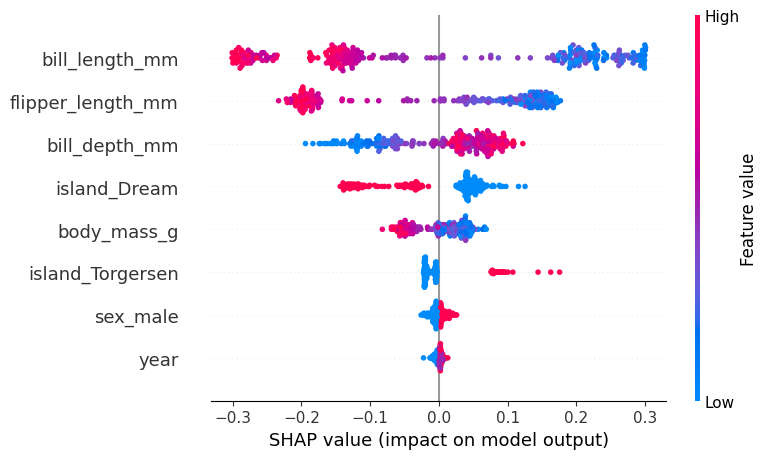

In [ ]:
# summary plot for class 0 = Adelie
...

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_10743/769462219.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


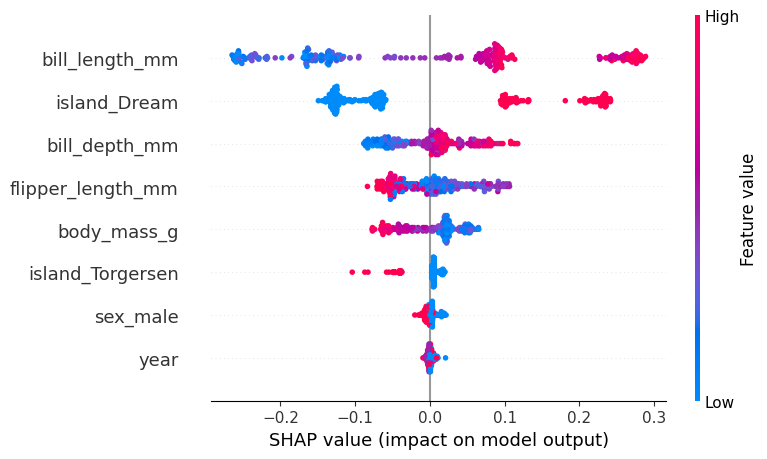

In [ ]:
# summary plot for class 1 = Chinstrap
...

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_10743/3322090008.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


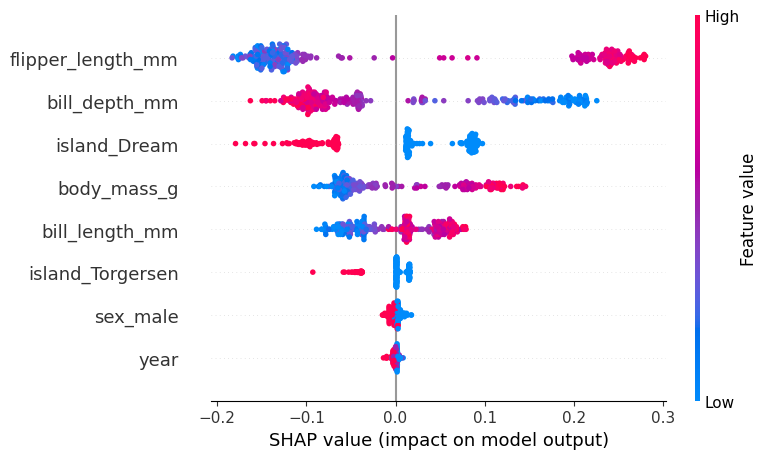

In [ ]:
# summary plot for class 2 = Gentoo
...

<font color='green'>

#### Question 3: What conclusions can you draw from the summary plots above?


<font color='grey'>

#### Your Answer:
...

### Interpretation with Forest-Guided Clustering

In the [Gen-4-Tutorial_FGC.ipynb](./Gen-4-Tutorial_FGC.ipynb) notebook you were introduced to the Random Forest specific FGC method. Recall, FGC does not assume independence of model features, because it computes the feature importance based on subgroups of instances that follow similar decision rules within the Random Forest model.

Even though the Random Forest Feature Importance and SHAP do overcome some disadvantages of Permutation Feature Importance and give us some information about class-wise feature contributions, they do not give us further insights into the decision paths of the Random Forest model. Forest-Guided Clustering (FGC) leverages the tree structure of Random Forest models to get insights into the decision making process of the model, which might be able to help us out here...

<font color='green'>

#### Task 5: Run FGC on the trained Random Forest model. Therefore, define the FgClustering object and run fgc by filling in the lines below.

In [ ]:
# create an FGC instance
fgc = ...

# Run the fgc instance
fgc.run()

Interpreting RandomForestClassifier


 33%|███▎      | 2/6 [00:01<00:02,  1.75it/s]

For number of cluster 2 the Jaccard Index is 0.8853301722947294
For number of cluster 2 the score is 0.3593212884282253
For number of cluster 3 the Jaccard Index is 1.0
For number of cluster 3 the score is 0.0174447873487719


 50%|█████     | 3/6 [00:01<00:01,  2.40it/s]

For number of cluster 4 the Jaccard Index is 0.9982243017146888
For number of cluster 4 the score is 0.026408044397251973


 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

For number of cluster 5 the Jaccard Index is 0.9307077873107285
For number of cluster 5 the score is 0.02112643551780158


 83%|████████▎ | 5/6 [00:02<00:00,  2.51it/s]

For number of cluster 6 the Jaccard Index is 0.6426387671697052
For number of cluster 6 the score is 0.020544263012948576


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

For number of cluster 7 the Jaccard Index is 0.6188298656478285
For number of cluster 7 the score is 0.017609368296813064
Optimal number of cluster is: 3


When training the model, we encoded some features and standardized the feature values beforehand. However, in the visualizations it would be nice to show the original features, which is possible with FGC. Therefore, we decode and back-transform the features to the original space and then re-calculate the cluster-wise statistics.

In [ ]:
# get original unscaled feature values
scaler = data_and_model[5]
X_train_original = scaler.inverse_transform(X_train)
X_train_original = pd.DataFrame(X_train_original, columns = X_train.columns)

# covert dummy encoded features back to category and recalculate p-value statistics
dummies_island = pd.DataFrame({"Torgersen": X_train_original['island_Torgersen'], "Dream": X_train_original['island_Dream'], "Biscoe": pd.Series(X_train_original['island_Dream'] + X_train_original['island_Torgersen']).replace({0:1, 1:0})})
X_train_original['island'] = pd.Series(dummies_island.columns[np.where(dummies_island!=0)[1]]).astype('category')

dummies_sex = pd.DataFrame({"male": X_train_original['sex_male'], "female": X_train_original['sex_male'].replace({0:1, 1:0})})
X_train_original['sex'] = pd.Series(dummies_sex.columns[np.where(dummies_sex!=0)[1]]).astype('category')

X_train_original = X_train_original.drop(columns=["island_Torgersen", "island_Dream", "sex_male"])

fgc.calculate_statistics(data=X_train_original, target_column=y_train)

Lets now plot the global and local FGC feature importance.

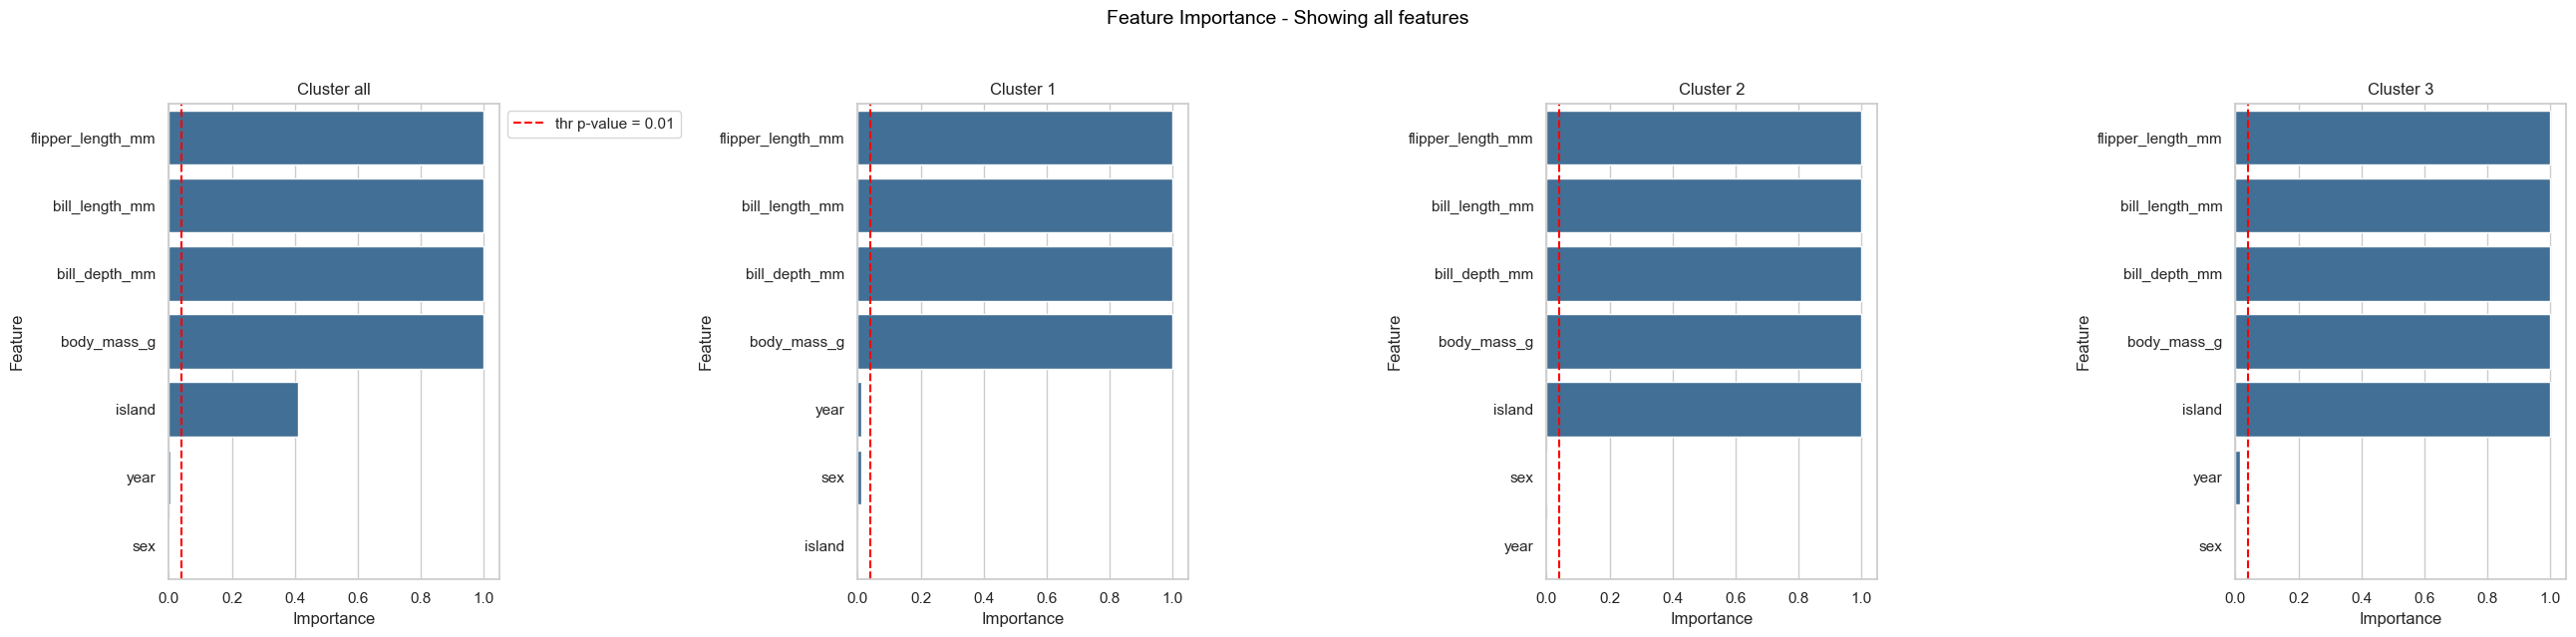

In [ ]:
%matplotlib inline
# Plot global feature importance
fgc.plot_feature_importance(thr_pvalue=0.01)

One of the major advantages of FGC is the visualization of the Random Forest decision path, which can help us to understand the decision making process of our model.

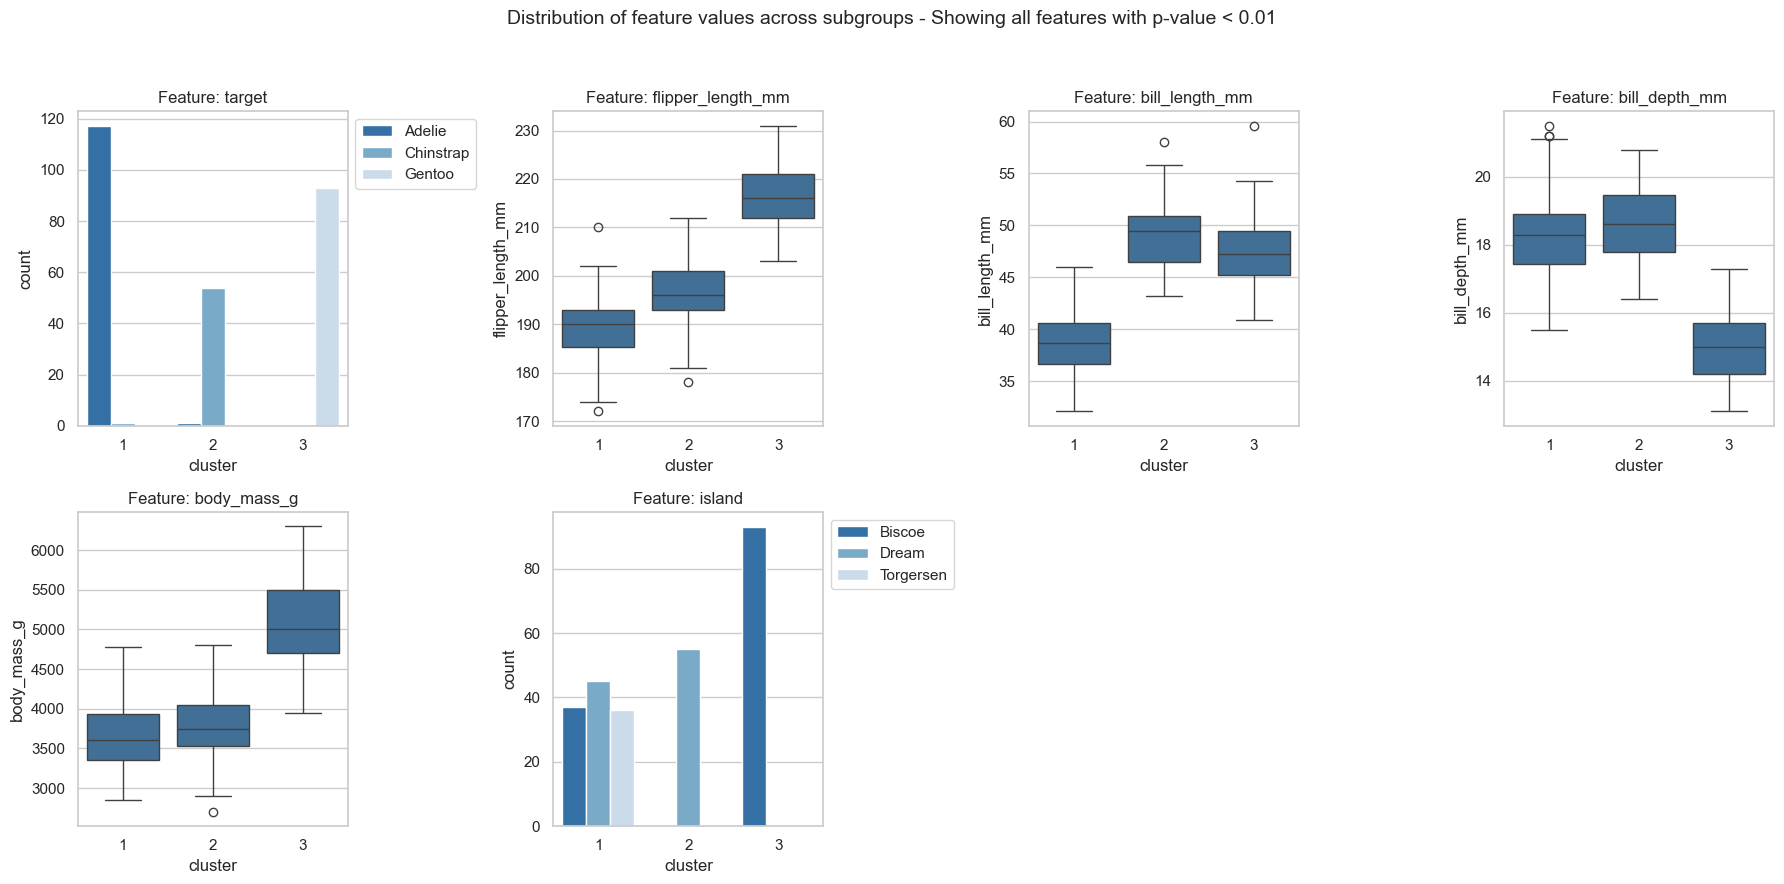

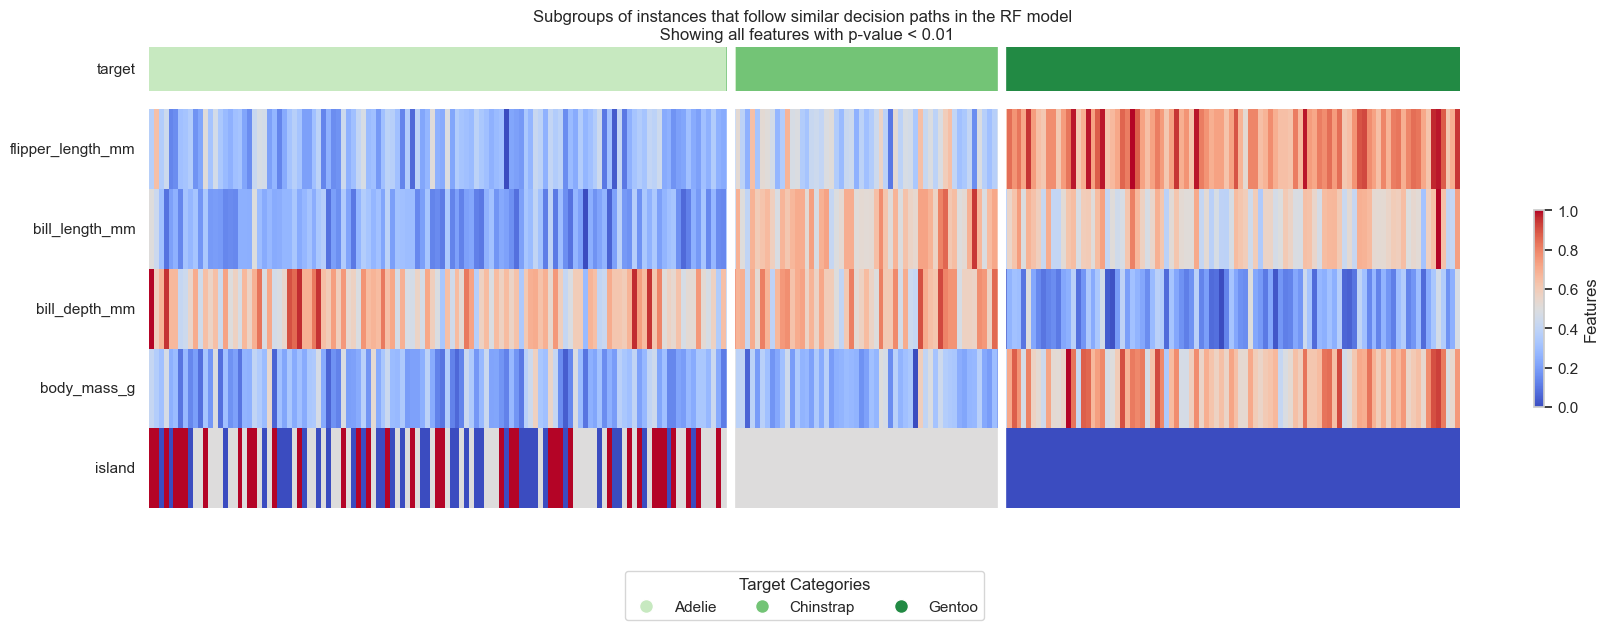

In [ ]:
fgc.plot_decision_paths(thr_pvalue=0.01, num_cols = 4)

<font color='green'>

#### Question 4: What do you observe when comparing the Permutation Feature Importance, Random Forest Feature Importance, SHAP Bar Plot and the FGC Feature Importance?

<font color='grey'>

#### Your Answer:
...

<font color='green'>

#### Question 5: What do you observe when comparing the SHAP Beeswarm Plots and the FGC Decision Path Plot?


<font color='grey'>

#### Your Answer:
...

<font color='green'>

#### Question 6: Try to describe each species (Adelie = 0, Chinstrap = 1, Gentoo = 2). Use the following examples to guide you:


<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_penguins_billlength.png?raw=true" width="200" /></center>

<font color='grey'>

#### Your Answer:
...